In [20]:
# KAGGLE DIGIT RECOGNITION USING CNN. 
# ACCURACY ON KAGGLE TRAINING SET 0.98860
# ACCURACY ON CROSS VALIDATION SET : 0.99178 
# ACCURACY ON KAGGLE TEST SET : 0.99371
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf

from pandas import DataFrame as df
from pandas import Series as sr
from sklearn.model_selection import StratifiedShuffleSplit as strat

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras import backend
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore') # IGNORE DEPRECATION (AND OTHER WARNINGS).

In [21]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [22]:
features = train.copy()
labels = train['label']
test_features = test.copy()

In [23]:
features.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
print(features.shape, labels.shape)

(42000, 785) (42000,)


In [25]:
# SPLITTING ORIGINAL TRAINING DATA INTO TRAINING AND VALIDATION DATA IN A STRATIFIED MANNER.
split = strat(test_size=0.2, random_state=42)
for train_indices, valid_indices in split.split(features, features['label']):
    strat_train = features.loc[ train_indices ]
    strat_valid = features.loc[ valid_indices ]

In [26]:
# BOTH TRAINING AND VALIDATION SETS ARE STRATIFIED.
print('DIGIT   ORIGINAL        TRAINING         VALIDATION')
for i in range(10) :
    print(i, '   ', (features['label'] == i).sum() / len(features), \
                    (strat_train['label'] == i).sum() / len(strat_train), \
                    (strat_valid['label'] == i).sum() / len(strat_valid))

DIGIT   ORIGINAL        TRAINING         VALIDATION
0     0.09838095238095237 0.09836309523809524 0.09845238095238096
1     0.11152380952380953 0.11151785714285714 0.11154761904761905
2     0.09945238095238096 0.09946428571428571 0.0994047619047619
3     0.1035952380952381 0.10360119047619047 0.10357142857142858
4     0.09695238095238096 0.09696428571428571 0.09690476190476191
5     0.09035714285714286 0.09035714285714286 0.09035714285714286
6     0.0985 0.09851190476190476 0.09845238095238096
7     0.10478571428571429 0.10479166666666667 0.10476190476190476
8     0.09673809523809523 0.09672619047619048 0.09678571428571428
9     0.09971428571428571 0.09970238095238096 0.09976190476190476


In [27]:
# ONE-HOT ENCODING.
strat_train_x = strat_train.copy()
strat_train_x.drop(['label'], axis=1, inplace=True)
strat_train_y = pd.get_dummies(strat_train['label'])

strat_valid_x = strat_valid.copy()
strat_valid_x.drop(['label'], axis=1, inplace=True)
strat_valid_y = pd.get_dummies(strat_valid['label'])

In [28]:
# CONVERTING ALL DATAFRAMES TO NUMPY ARRAYS FOR FAST COMPUTATIONS.
strat_train_x = np.array(strat_train_x).reshape(-1, 28, 28, 1)
strat_train_y = np.array(strat_train_y)
strat_valid_x = np.array(strat_valid_x).reshape(-1, 28, 28, 1)
strat_valid_y = np.array(strat_valid_y)
test_features = np.array(test_features).reshape(-1, 28, 28, 1)
print(strat_train_x.shape, strat_train_y.shape, strat_valid_x.shape, strat_valid_y.shape, \
     test_features.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10) (28000, 28, 28, 1)


In [29]:
def plot_images(images, true, pred=None):

    figure = plt.figure( figsize = ( 15, 15 ) )

    for i in range(len(images)) :
        ax = figure.add_subplot( 3, 3, i + 1 )
        ax.imshow( images[i,:,:,0], cmap = 'binary' )
        if pred is None:
            ax.set_xlabel('True Label : {0}'.format(np.argmax(true[i])))
        else:
            ax.set_xlabel('True Label : {0}, Prediction : {1}'.format(true[i], pred[i]))
        ax.set_xticks([])
        ax.set_yticks([])

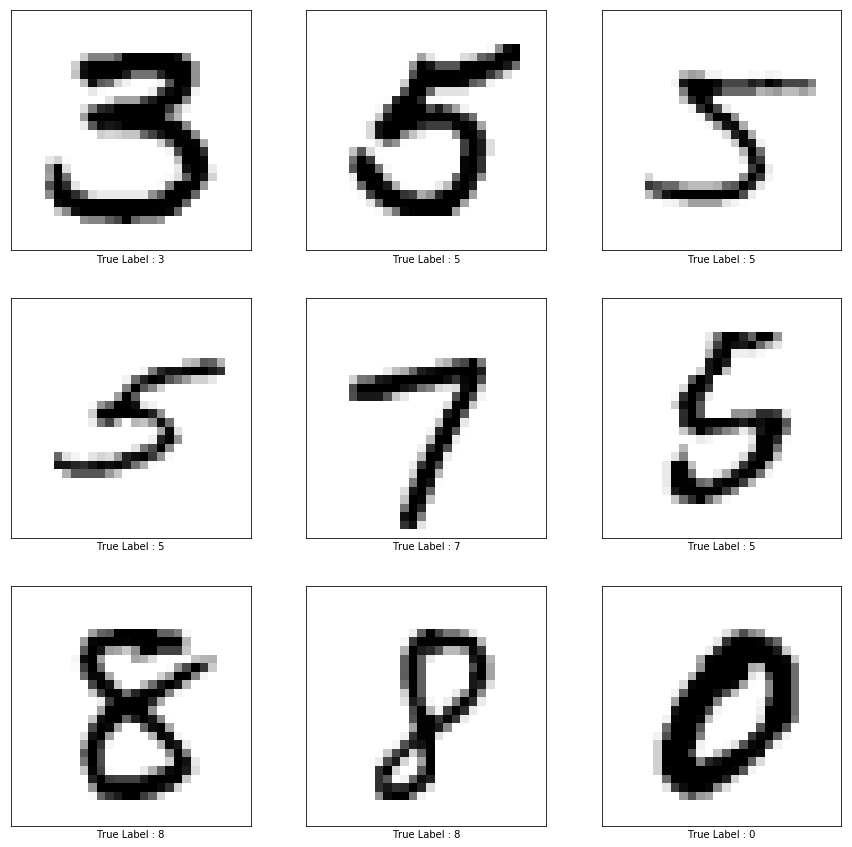

In [30]:
# PLOTTING FIRST NINE IMAGES WITH TRUE LABELS.
plot_images(strat_train_x[0:9, :, :, :], strat_train_y[0:9]) 

In [31]:
# COUNTS OF EACH DIGIT IN THE TRAINING SET.
label_counts = labels.value_counts()
label_counts.sort_index(inplace=True)
label_counts

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

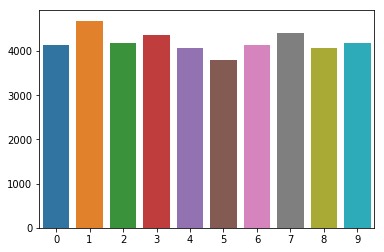

In [32]:
sns.barplot(x=list(range(0,10)), y=list(label_counts))

In [33]:
# CASTING VALUES TO FLOATS SO THAT THEY CAN BE NORMALISED.
strat_train_x = strat_train_x.astype('float32')
strat_valid_x = strat_valid_x.astype('float32')
test_features = test_features.astype('float32')

# NORMALISING ALL THE FEATURE VALUES.
strat_train_x /= 255 
strat_valid_x /= 255
test_features /= 255

In [34]:
# CREATING A CNN MODEL.
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [36]:
# USING CATEGORICAL CROSS ENTROPY BECAUSE THE LABELS ARE ONE-HOT ENCODED.
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# INTRODUCING SOME VARIATIONS(RANDOMLY) INTO THE NETWORK SO THE MODEL CAN GENERALISE BETTER AND 
# ALSO DO NOT OVERFIT.
image_preprocess = ImageDataGenerator(rotation_range=10, \
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)
image_preprocess.fit(strat_train_x)

In [38]:
# DECREASING ALPHA OR LEARNING RATE BY A FACTOR OF 10 EACH TIME VALIDATION SET ACCURACY DECREASES.
batch_size = 100
epochs = 10
alpha_vary = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=1, verbose=1)

In [39]:
# TRAINING THE MODEL.
model.fit_generator(image_preprocess.flow(strat_train_x, strat_train_y, batch_size=batch_size), \
                    steps_per_epoch=strat_train_x.shape[0] // batch_size, \
                    callbacks=[alpha_vary], \
                    validation_data=(strat_valid_x, strat_valid_y), \
                    epochs=epochs, \
                    verbose=2)

Epoch 1/10
 - 261s - loss: 0.2764 - acc: 0.9146 - val_loss: 0.0660 - val_acc: 0.9776
Epoch 2/10
 - 250s - loss: 0.0980 - acc: 0.9710 - val_loss: 0.0547 - val_acc: 0.9838
Epoch 3/10
 - 252s - loss: 0.0733 - acc: 0.9771 - val_loss: 0.0361 - val_acc: 0.9892
Epoch 4/10
 - 253s - loss: 0.0612 - acc: 0.9810 - val_loss: 0.0382 - val_acc: 0.9882

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
 - 258s - loss: 0.0440 - acc: 0.9862 - val_loss: 0.0305 - val_acc: 0.9908
Epoch 6/10
 - 261s - loss: 0.0384 - acc: 0.9883 - val_loss: 0.0338 - val_acc: 0.9901

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/10
 - 258s - loss: 0.0344 - acc: 0.9897 - val_loss: 0.0281 - val_acc: 0.9913
Epoch 8/10
 - 247s - loss: 0.0347 - acc: 0.9888 - val_loss: 0.0276 - val_acc: 0.9917
Epoch 9/10
 - 256s - loss: 0.0331 - acc: 0.9897 - val_loss: 0.0268 - val_acc: 0.9917

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.00000006568

In [40]:
# LOSS VALUE AND ACCURACY ON VALIDATION SET.
score = model.evaluate(strat_valid_x, strat_valid_y, verbose=0)
print('valid loss:', score[0])
print('valid accuracy:', score[1])

valid loss: 0.027003438824072613
valid accuracy: 0.9917857142857143


In [41]:
# PREDICTION ON KAGGLE TEST SET AND CONVERTING PROBABILITIES(AFTER SOFTMAX FUNCTION) TO CLASSES.
pred = np.argmax(model.predict(test_features), axis=1)

In [43]:
# WRITING TO A CSV FILE.
ids = range(1, len(pred)+1)
output = pd.DataFrame({"ImageId": ids , "Label": pred })
output.to_csv('output_cnn.csv', index=False)

In [46]:
# SAVING MODEL.
model.save('Digit_Recognition_Kaggle_CNN_099371_Model.h5')